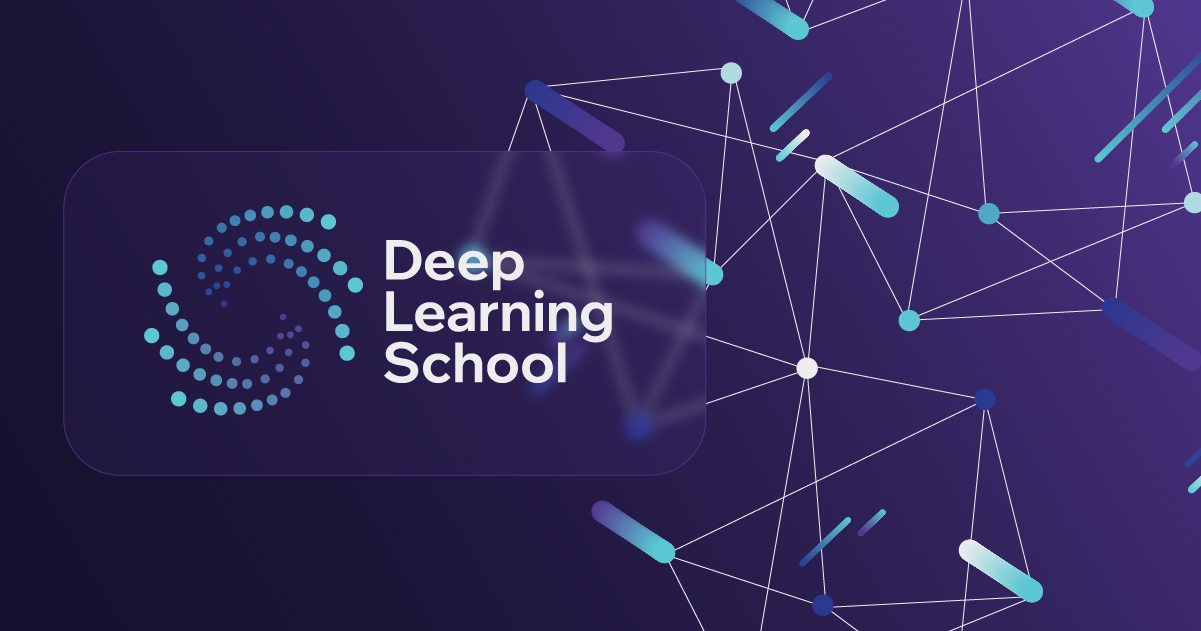


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import imageio
from PIL import Image
import kagglehub

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from torchvision import datasets, transforms

%matplotlib inline

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [2]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Path to dataset files: /kaggle/input/lfw-dataset


In [3]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Path to dataset files: /kaggle/input/lfw-attributes


In [4]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [5]:
def fetch_dataset(dx=80, dy=80, dimx=64, dimy=64):
    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1, )
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id, 'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    # mass-merge
    # (photos now have same order as attributes)
    df = pd.merge(df_attrs, photo_ids, on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "lost some data when merging dataframes"

    # print(df.shape)
    # image preprocessing
    all_photos = df['photo_path'].apply(skimage.io.imread) \
        .apply(lambda img: img[dy:-dy, dx:-dx]) \
        .apply(lambda img: resize(img, [dimx, dimy]))

    all_photos = np.stack(all_photos.values)  # .astype('uint8')
    all_attrs = df.drop(["photo_path", "imagenum"], axis=1)

    return all_photos, all_attrs

In [6]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()


Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Разделим данные на train и val и преобразуем в тензоры торча

train_data, valid_data = train_test_split(images, test_size=0.2, random_state=42)

train_data = torch.tensor(train_data).permute(0, 3, 1, 2).float().to(device)
valid_data = torch.tensor(valid_data).permute(0, 3, 1, 2).float().to(device)

In [9]:
# Создадим DataLoader

batch_size = 64
train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_data), batch_size=batch_size, shuffle=False)

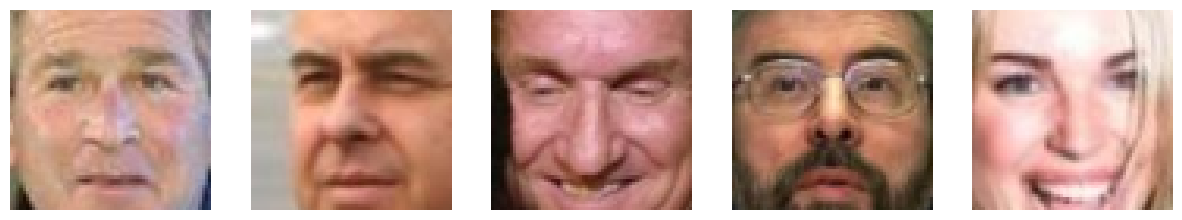

In [10]:
#Визулизируем несколько изображений

fig, axes = plt.subplots(1, 5, figsize=(15,5))
for i, ax in enumerate(axes):
  ax.imshow(train_data[i + 10].permute(1, 2, 0).cpu().numpy())
  ax.axis('off')
plt.show()

## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



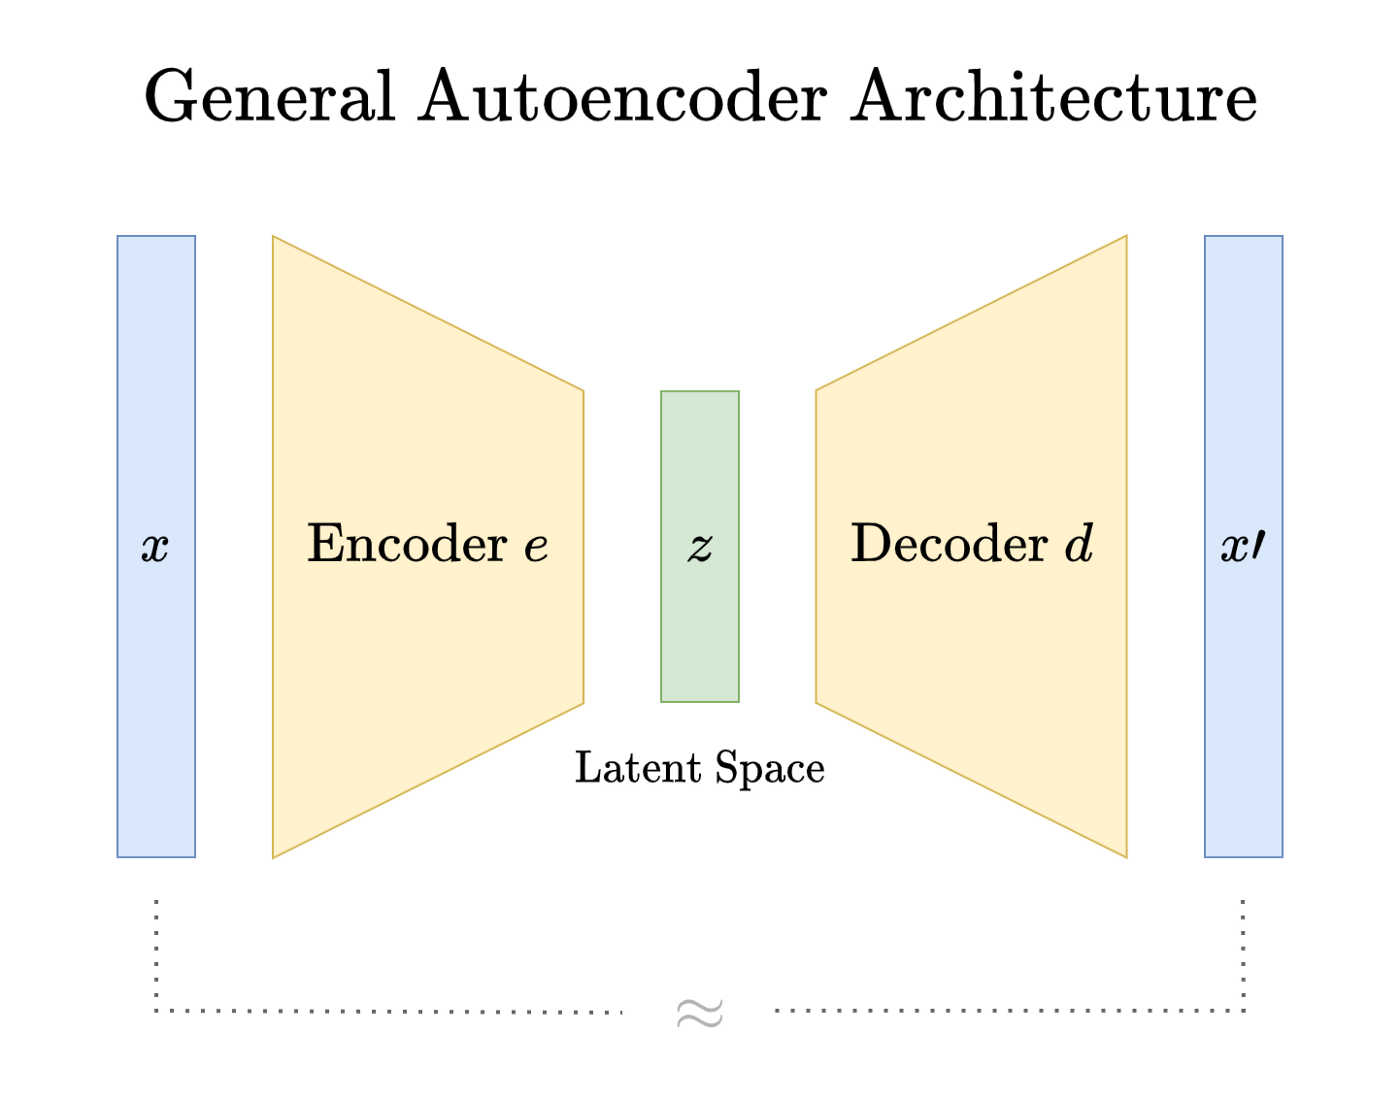

In [11]:
dim_code = 128 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [12]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
      super(Autoencoder, self).__init__()

      # Encoder
      self.encoder = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
          nn.ReLU(),
          nn.Flatten(),
          nn.Linear(128 * 16 * 16, dim_code)
      )

      # Decoder
      self.decoder = nn.Sequential(
          nn.Linear(dim_code, 128 * 16 * 16),
          nn.ReLU(),
          nn.Unflatten(1, (128, 16, 16)),
          nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
          nn.Sigmoid()
      )

    def forward(self, x):
      latent_code = self.encoder(x)
      reconstruction = self.decoder(latent_code)
      return reconstruction, latent_code

In [13]:
criterion = nn.MSELoss()
autoencoder = Autoencoder().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

Epoch 1/20, Train Loss: 0.0181, Valid Loss: 0.0088


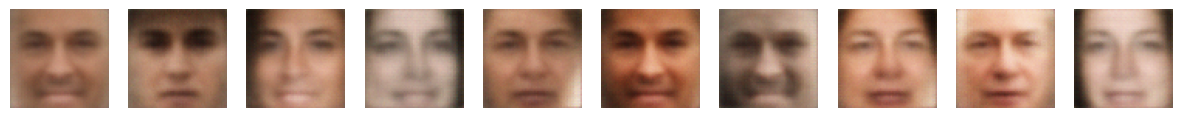

Epoch 2/20, Train Loss: 0.0068, Valid Loss: 0.0057


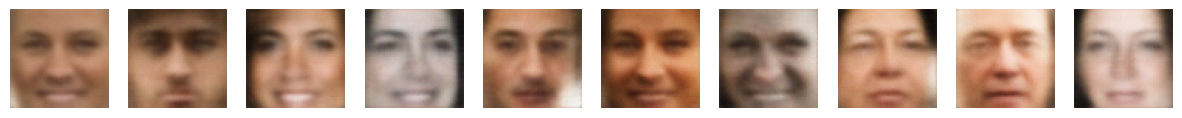

Epoch 3/20, Train Loss: 0.0047, Valid Loss: 0.0043


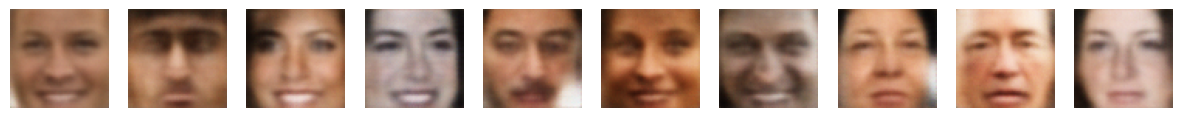

Epoch 4/20, Train Loss: 0.0036, Valid Loss: 0.0035


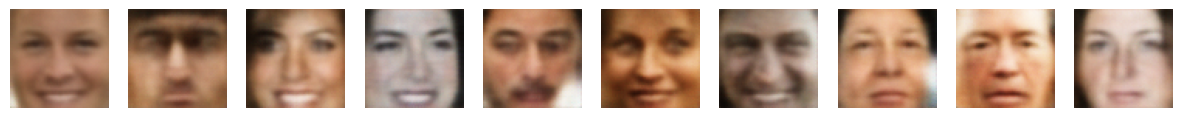

Epoch 5/20, Train Loss: 0.0030, Valid Loss: 0.0030


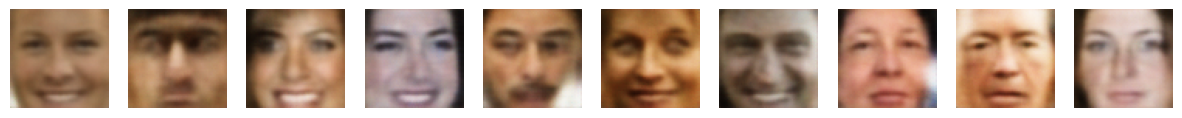

Epoch 6/20, Train Loss: 0.0027, Valid Loss: 0.0031


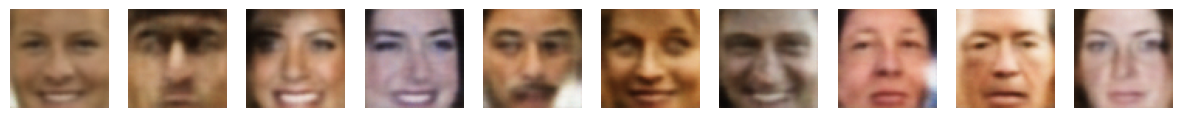

Epoch 7/20, Train Loss: 0.0024, Valid Loss: 0.0025


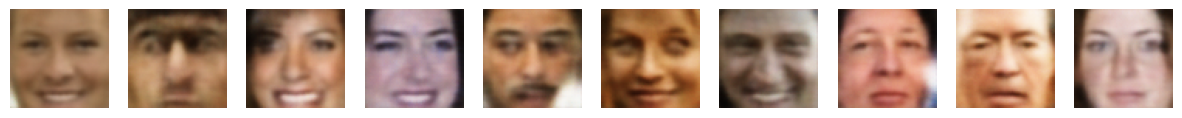

Epoch 8/20, Train Loss: 0.0023, Valid Loss: 0.0025


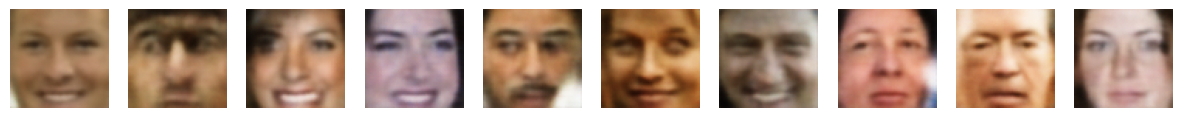

Epoch 9/20, Train Loss: 0.0021, Valid Loss: 0.0025


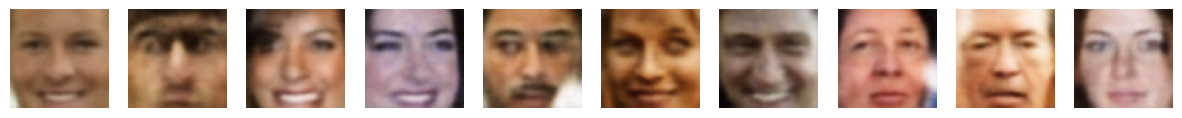

Epoch 10/20, Train Loss: 0.0020, Valid Loss: 0.0024


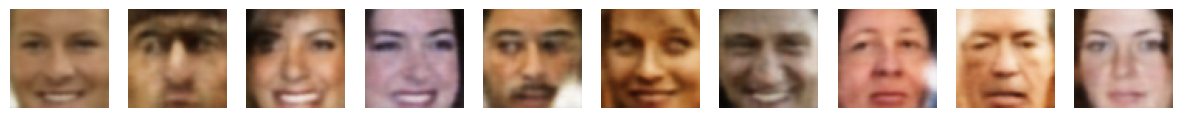

Epoch 11/20, Train Loss: 0.0020, Valid Loss: 0.0023


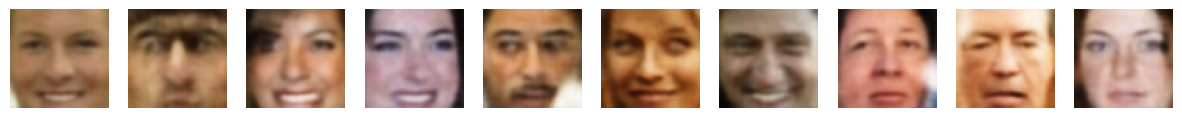

Epoch 12/20, Train Loss: 0.0019, Valid Loss: 0.0023


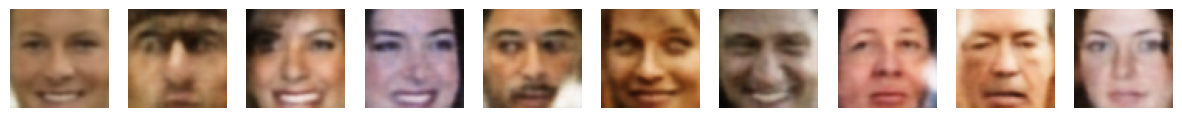

Epoch 13/20, Train Loss: 0.0019, Valid Loss: 0.0023


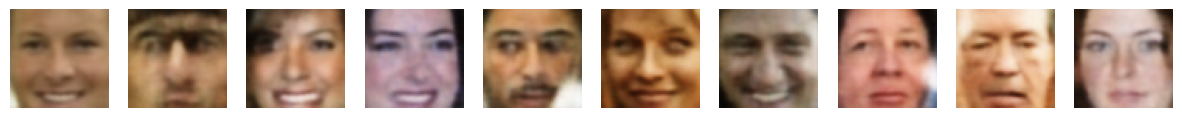

Epoch 14/20, Train Loss: 0.0018, Valid Loss: 0.0022


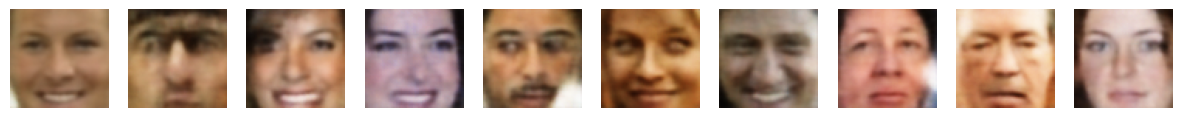

Epoch 15/20, Train Loss: 0.0017, Valid Loss: 0.0023


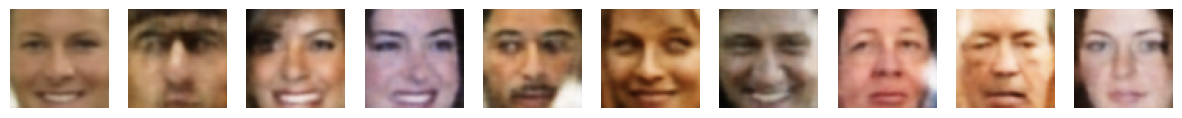

Epoch 16/20, Train Loss: 0.0017, Valid Loss: 0.0023


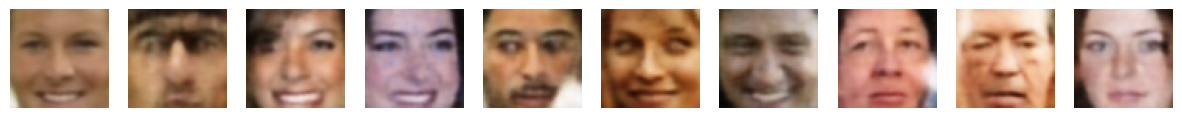

Epoch 17/20, Train Loss: 0.0016, Valid Loss: 0.0023


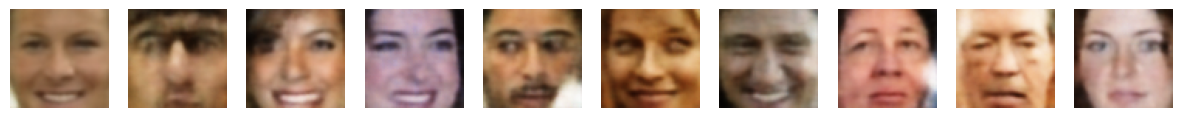

Epoch 18/20, Train Loss: 0.0016, Valid Loss: 0.0023


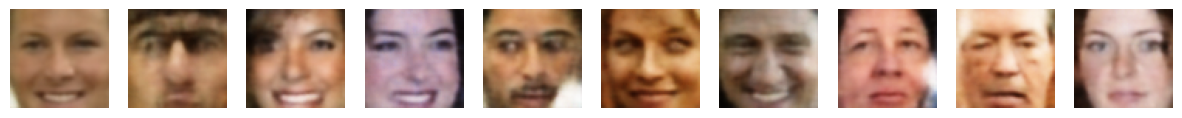

Epoch 19/20, Train Loss: 0.0016, Valid Loss: 0.0022


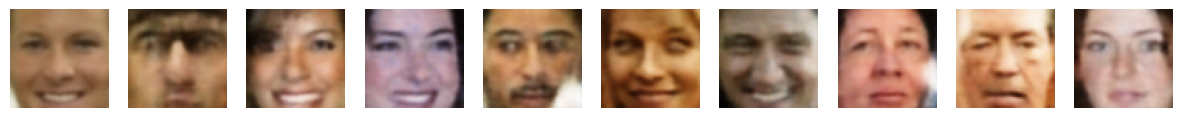

Epoch 20/20, Train Loss: 0.0015, Valid Loss: 0.0022


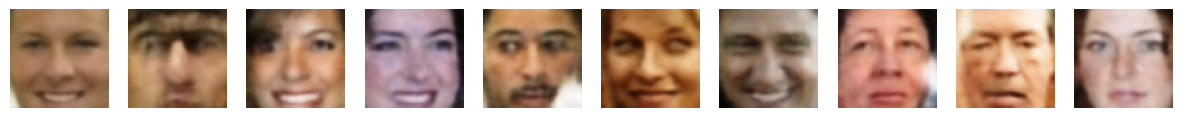

In [14]:
epochs = 20
train_losses = []
valid_losses = []

for epoch in range(epochs):

    autoencoder.train()
    train_loss = 0.0

    for batch in train_loader:
        imgs = batch[0].to(device)
        optimizer.zero_grad()
        reconstruction, _ = autoencoder(imgs)
        loss = criterion(reconstruction, imgs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)  # Средний по имэджам лосс на эпохе трейна
    train_losses.append(train_loss)

    # Оценка на валидации
    autoencoder.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for batch in valid_loader:
            imgs = batch[0].to(device)
            reconstruction, _ = autoencoder(imgs)
            loss = criterion(reconstruction, imgs)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)  # Средний по имэджам лосс на эпохе валидации
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    sample_images = next(iter(valid_loader))[0].to(device)
    reconstructed, _ = autoencoder(sample_images)

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axes[i].imshow(reconstructed[i].detach().permute(1, 2, 0).cpu().numpy())
        axes[i].axis('off')
    plt.show()


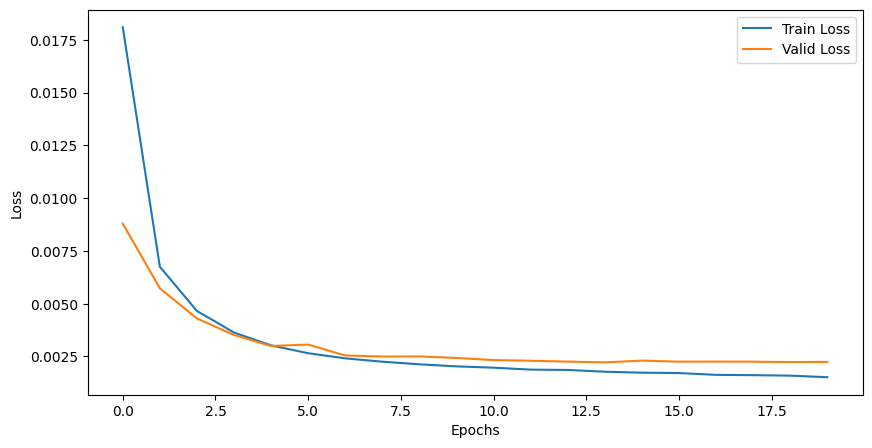

In [15]:
# Построение графиков лоссов
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

In [ ]:
count = 5
sample_images = next(iter(valid_loader))[0][5 : 5 + count]
reconstructed, _ = autoencoder(sample_images)

fig, axes = plt.subplots(2, count, figsize=(15, 5))
for i in range(count):
    axes[0, i].imshow(sample_images[i].permute(1, 2, 0).cpu().numpy())
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].detach().permute(1, 2, 0).cpu().numpy())
    axes[1, i].axis('off')
plt.show

Что вы можете сказать про результат?

В целом то неплохо

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

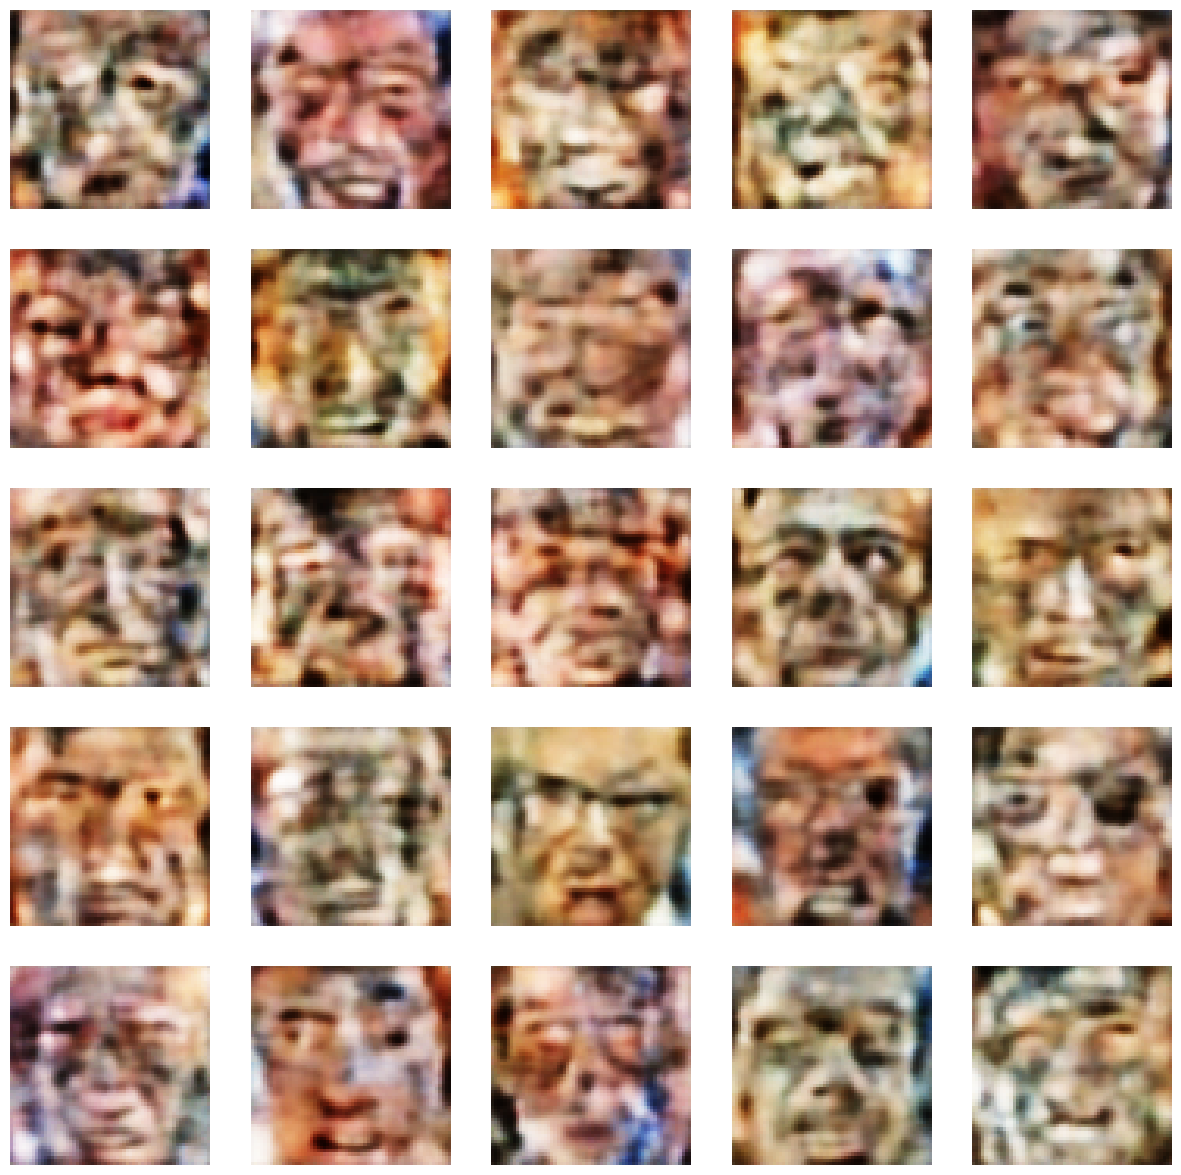

In [17]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.randn(25, dim_code).to(device)
with torch.no_grad():
    generated_images = autoencoder.decoder(z)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].detach().cpu().permute(1, 2, 0).numpy())
    ax.axis('off')
plt.show()

In [18]:
# Подглянем на наше латентное пространство
real_images = next(iter(valid_loader))[0].to(device)

with torch.no_grad():
    _, real_latent_vectors = autoencoder(real_images)

real_latent_vectors = real_latent_vectors.cpu().numpy()

In [19]:
# узнаем стандартное отклонение и среднее
latent_mean = np.mean(real_latent_vectors, axis=0)
latent_std = np.std(real_latent_vectors, axis=0)

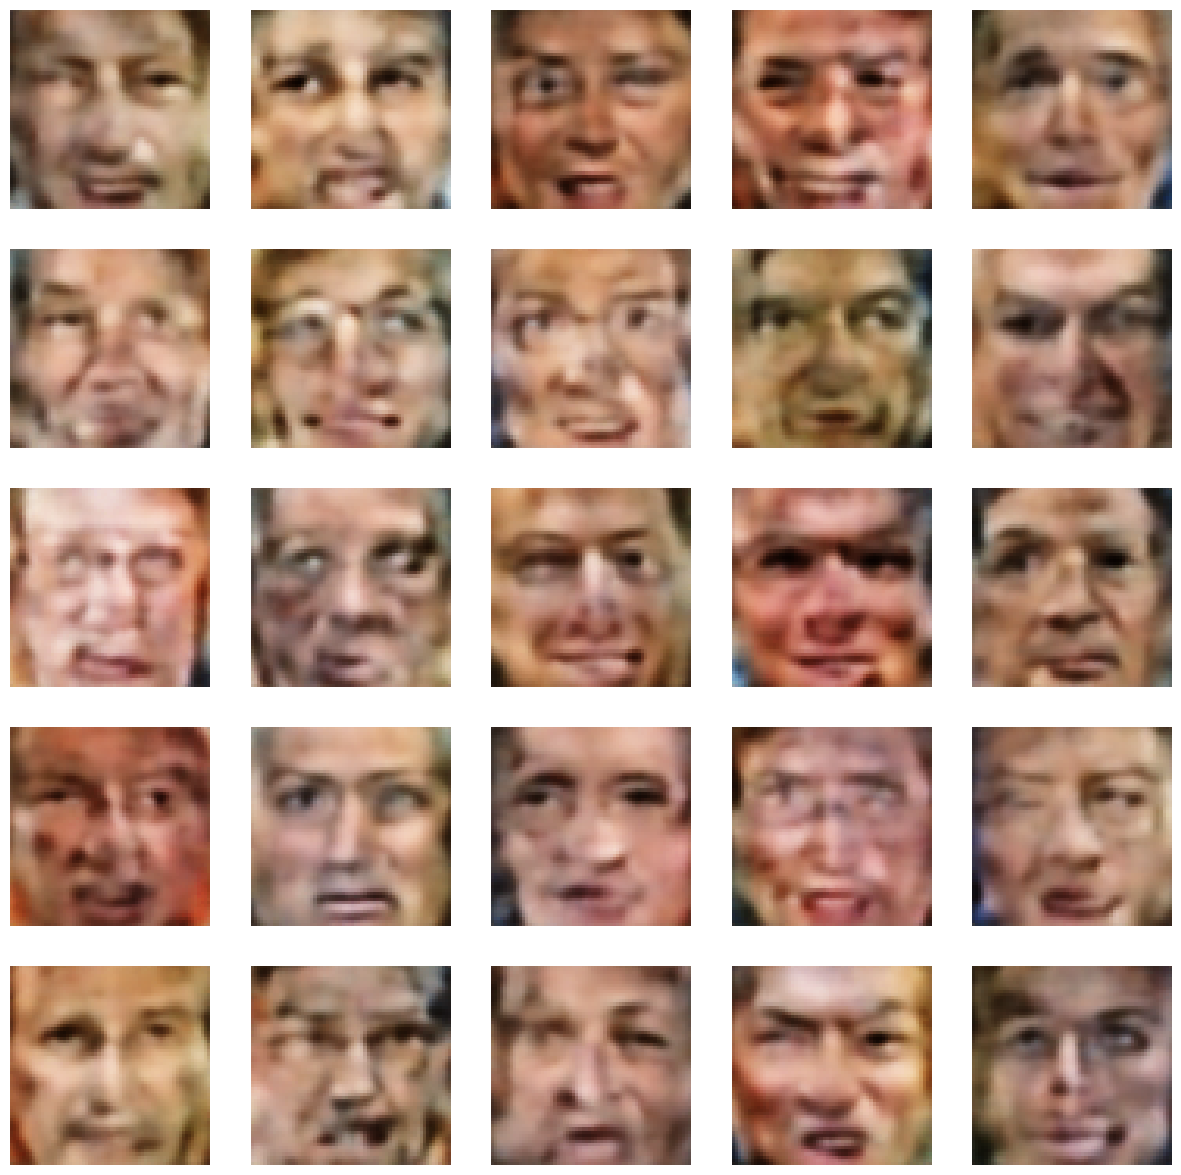

In [20]:
# а теперь уже на основе этого распределения попытаемся сгенерировать новых красавцев
z = np.random.normal(loc=latent_mean, scale=latent_std, size=(25, dim_code))

# Конвертнем в pytorch тензор
z = torch.tensor(z, dtype=torch.float32).to(device)

with torch.no_grad():
    generated_images = autoencoder.decoder(z)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].detach().cpu().permute(1, 2, 0).numpy())
    ax.axis('off')
plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [21]:
# Разделим данные на улыбающихся и грустных
smiling_indices = attrs.index[attrs['Smiling'] > 0.75].tolist()
non_smiling_indices = attrs.index[attrs['Smiling'] < -0.75].tolist()

smiling_images = [images[i] for i in smiling_indices]
non_smiling_images = [images[i] for i in non_smiling_indices]


In [22]:
# Ограничим выборку 15 изображениями для каждого класса
smiling_images = smiling_images[:15]
non_smiling_images = non_smiling_images[:15]

In [23]:
# Переведем их в тензоры и отправим на гпу
smiling_images = torch.tensor(smiling_images).permute(0, 3, 1, 2).float().to(device)
non_smiling_images = torch.tensor(non_smiling_images).permute(0, 3, 1, 2).float().to(device)

<ipython-input-23-654acc075a5d>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  smiling_images = torch.tensor(smiling_images).permute(0, 3, 1, 2).float().to(device)


In [24]:
# Прогоняем изображения через encoder для получения латентных векторов
smiling_latents = autoencoder.encoder(smiling_images).detach()
non_smiling_latents = autoencoder.encoder(non_smiling_images).detach()

# Вычисляем средние латентные векторы
mean_smiling = smiling_latents.mean(dim=0)
mean_non_smiling = non_smiling_latents.mean(dim=0)

In [25]:
smile_vector = (mean_smiling - mean_non_smiling) * 1

In [26]:
def add_smile(image_tensor):
    latent = autoencoder.encoder(image_tensor.unsqueeze(0)).detach()
    new_latent = latent + smile_vector.unsqueeze(0)
    reconstructed = autoencoder.decoder(new_latent).squeeze(0)
    return reconstructed

In [27]:
# Выбираем одно грустное изображение для примера
sample_image = non_smiling_images[2]
smiling_version = add_smile(sample_image)

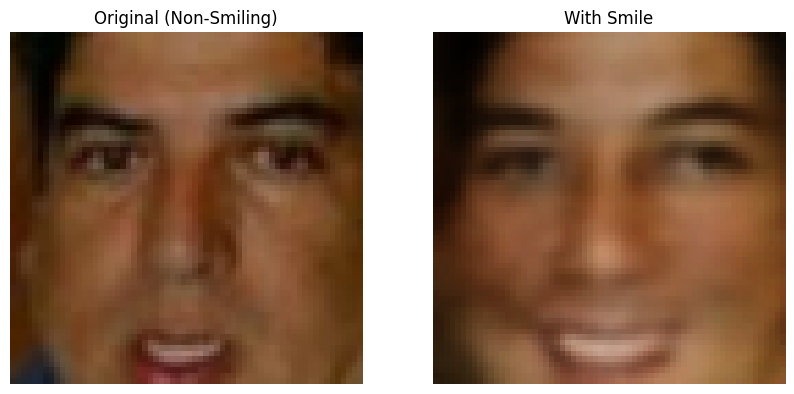

In [28]:
# Визуализация результата
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sample_image.permute(1, 2, 0).detach().cpu().numpy())
axes[0].set_title("Original (Non-Smiling)")
axes[0].axis('off')

axes[1].imshow(smiling_version.permute(1, 2, 0).detach().cpu().numpy())
axes[1].set_title("With Smile")
axes[1].axis('off')

plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [29]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [30]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, 20)  # mu
        self.fc_logsigma = nn.Linear(128, 20)  # logsigma

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(20, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logsigma = self.fc_logsigma(h)
        return mu, logsigma

    # reparameterization trick
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std) # std в параметрах randn_like это размер
            return mu + eps * std
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 64, 7, 7)
        reconstruction = self.decoder_conv(h)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [31]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp(), dim=1).mean()

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    return F.binary_cross_entropy(reconstruction, x, reduction='sum') / x.size(0)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [32]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [33]:
epochs = 10
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = vae(x)
        loss = loss_vae(x, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}")

Epoch 1/10, Loss: 4.3344
Epoch 2/10, Loss: 3.3765
Epoch 3/10, Loss: 3.2716
Epoch 4/10, Loss: 3.2180
Epoch 5/10, Loss: 3.1812
Epoch 6/10, Loss: 3.1534
Epoch 7/10, Loss: 3.1293
Epoch 8/10, Loss: 3.1107
Epoch 9/10, Loss: 3.0976
Epoch 10/10, Loss: 3.0849


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

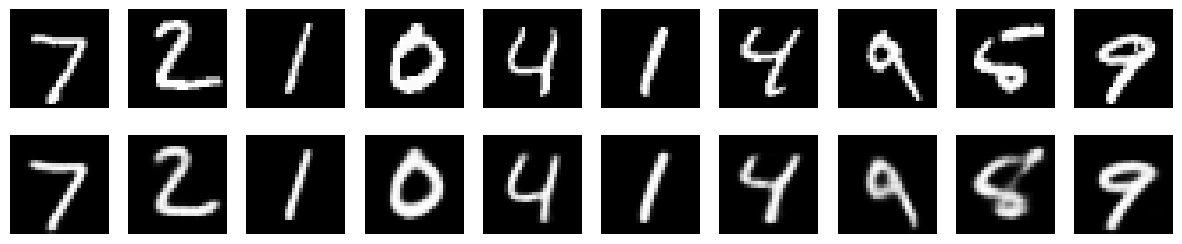

In [34]:
# Визуализация реконструкций
vae.eval()
data_iter = iter(test_loader)
images, _ = next(data_iter)
images = images.to(device)
mu, logsigma, reconstructions = vae(images)

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructions[i].cpu().detach().squeeze(), cmap='gray')
    axes[1, i].axis('off')
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

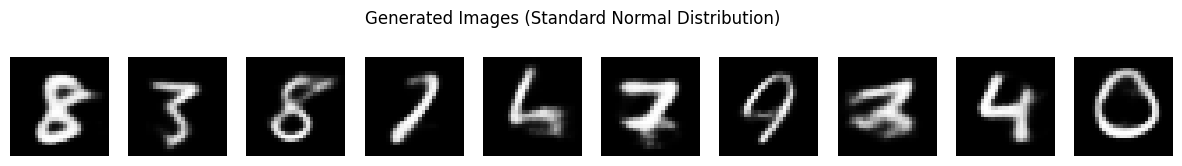

In [35]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z_std_normal = torch.tensor(np.random.normal(0, 1, (10, 20))).float().to(device)  # 10 латентных векторов размерности 20
output_std = vae.decode(z_std_normal)  # скормим декодеру
output_std = output_std.detach().cpu().numpy()

# Визуализация картинок, полученных в первом варианте
plt.figure(figsize=(15, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(output_std[i][0], cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Images (Standard Normal Distribution)")
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [36]:
from sklearn.manifold import TSNE

In [37]:
# Получение латентных представлений для тестового датасета
def get_latent_vectors(vae, loader):
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            mu, _, _ = vae(x)
            latent_vectors.append(mu.cpu().numpy())
            labels.append(y.numpy())
    return np.vstack(latent_vectors), np.hstack(labels)


In [38]:
# Получаем латентные векторы и соответствующие метки
latent_vectors, labels = get_latent_vectors(vae, test_loader)

# Применяем t-SNE для уменьшения размерности до 2
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

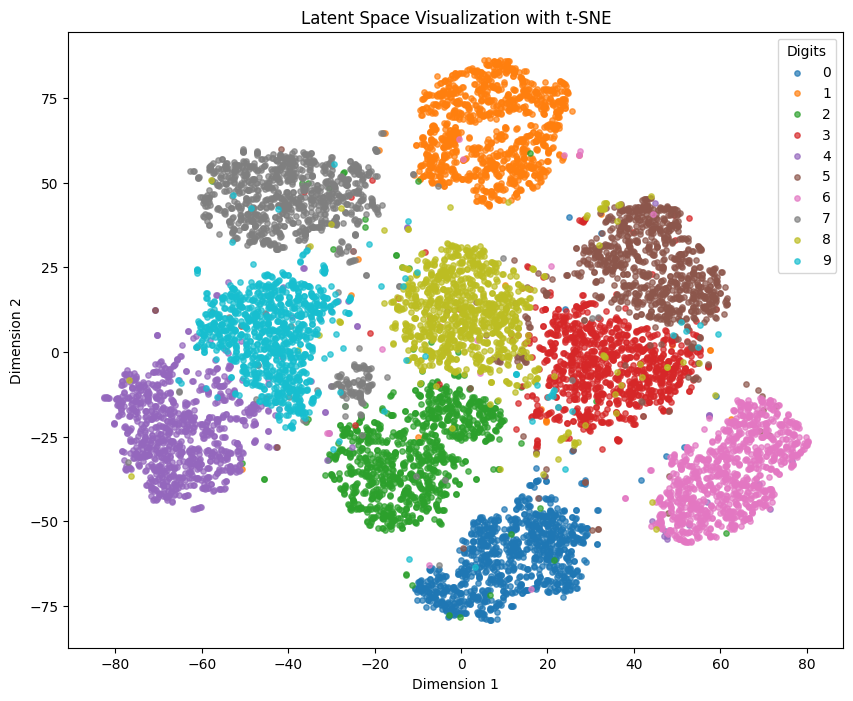

In [39]:
# Визуализация с использованием scatter
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10  # Набор из 10 цветов для цифр 0-9
for digit in range(10):
    mask = labels == digit
    plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1], c=[colors(digit)], label=str(digit), s=15, alpha=0.7)

plt.title("Latent Space Visualization with t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Digits", loc="best")
plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [40]:
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, class_dim, hidden_dim):
        super(CVAE, self).__init__()

        # Encoder
        self.encoder_fc = nn.Linear(input_dim + class_dim, hidden_dim)
        self.mu_fc = nn.Linear(hidden_dim, latent_dim)
        self.logsigma_fc = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim + class_dim, hidden_dim)
        self.decoder_fc2 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, class_num):
        x = torch.cat([x, class_num], dim=1)
        hidden = F.relu(self.encoder_fc(x))
        mu = self.mu_fc(hidden)
        logsigma = self.logsigma_fc(hidden)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, class_num):
        z = torch.cat([z, class_num], dim=1)
        hidden = F.relu(self.decoder_fc1(z))
        reconstruction = torch.sigmoid(self.decoder_fc2(hidden))
        return reconstruction

    def forward(self, x, class_num):
        mu, logsigma = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

In [41]:
# Тренируем
input_dim = 28 * 28
latent_dim = 20
class_dim = 10
hidden_dim = 400

cvae = CVAE(input_dim, latent_dim, class_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-3)

for epoch in range(10):
    for batch in train_loader:
        images, labels = batch
        images = images.view(-1, input_dim).to(device)
        labels_onehot = F.one_hot(labels, num_classes=class_dim).float().to(device)

        optimizer.zero_grad()
        mu, logsigma, recon_images = cvae(images, labels_onehot)
        loss = loss_vae(images, mu, logsigma, recon_images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{10}, Loss: {train_loss:.4f}")

Epoch 1/10, Loss: 4.1955
Epoch 2/10, Loss: 3.4514
Epoch 3/10, Loss: 3.3356
Epoch 4/10, Loss: 3.2782
Epoch 5/10, Loss: 3.2422
Epoch 6/10, Loss: 3.2166
Epoch 7/10, Loss: 3.1965
Epoch 8/10, Loss: 3.1802
Epoch 9/10, Loss: 3.1681
Epoch 10/10, Loss: 3.1554


### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

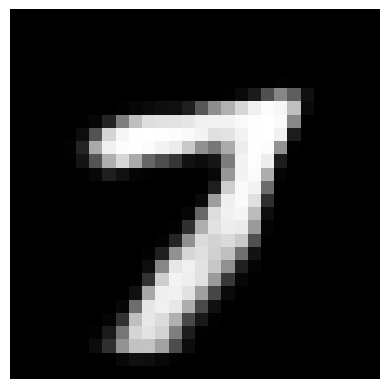

In [42]:
sample_class = torch.tensor([7]).to(device)
sample_class_onehot = F.one_hot(sample_class, num_classes=class_dim).float()
sample_z = torch.randn(1, latent_dim).to(device)
sample_image = cvae.decode(sample_z, sample_class_onehot)

plt.imshow(sample_image.view(28, 28).detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [43]:
def visualize_latent_space(model, dataloader):
    latents, labels = [], []
    for batch in dataloader:
        images, batch_labels = batch
        images = images.view(-1, input_dim).to(device)
        labels_onehot = F.one_hot(batch_labels, num_classes=class_dim).float().to(device)

        mu, _ = model.encode(images, labels_onehot)
        latents.append(mu.detach().cpu().numpy())
        labels.append(batch_labels.cpu().numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    tsne = TSNE(n_components=2)
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.colorbar(scatter, label="Class")
    plt.title("Latent Space Visualization")
    plt.show()

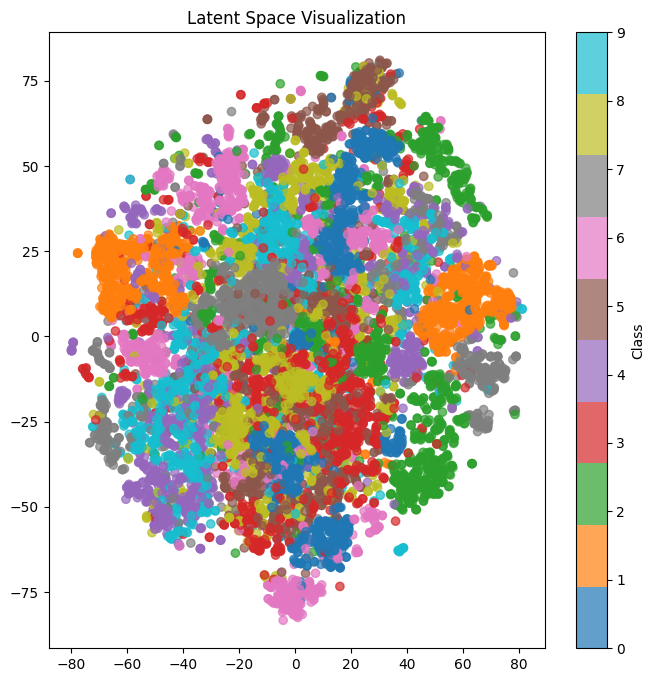

In [44]:
visualize_latent_space(cvae, test_loader)

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Да, отличается. VAE сам старается выучивать как-то информацию о различии классов, поэтому в его латентном представлении данная информация присутствует. А вот в CVAE получает знания о классах извне, поэтому наш латентный вектор это какая-то каша из вектора изображения + one hot лейбла

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [45]:
def noise_batch(source_batch: torch.Tensor, noise_factor=0.5) -> torch.Tensor:
    noisy_batch = source_batch + noise_factor * torch.randn_like(source_batch)
    return torch.clamp(noisy_batch, 0, 1)

In [46]:
images, attrs = fetch_dataset()
train_data, valid_data, train_attrs, valid_attrs = train_test_split(images, attrs, test_size=0.2, random_state=42)
train_data = torch.tensor(train_data).permute(0, 3, 1, 2).float().to(device)
valid_data = torch.tensor(valid_data).permute(0, 3, 1, 2).float().to(device)

In [47]:
noise_factor = 0.7

noisy_train = noise_batch(train_data, noise_factor=noise_factor)
noisy_valid = noise_batch(valid_data, noise_factor=noise_factor)

noisy_train_loader = DataLoader(TensorDataset(noisy_train), batch_size=64, shuffle=True)
noisy_valid_loader = DataLoader(TensorDataset(noisy_valid), batch_size=64, shuffle=False)

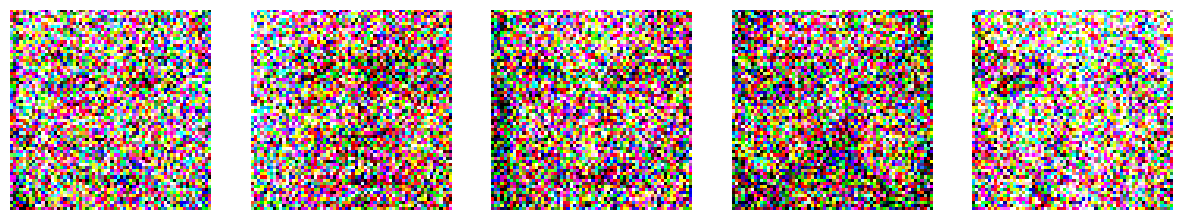

In [48]:
#Визулизируем несколько изображений

fig, axes = plt.subplots(1, 5, figsize=(15,5))
for i, ax in enumerate(axes):
  ax.imshow(noisy_train[i + 10].permute(1, 2, 0).cpu().numpy())
  ax.axis('off')
plt.show()

In [49]:
criterion = nn.MSELoss()
autoencoder_noisy = Autoencoder().to(device)
optimizer = optim.AdamW(autoencoder_noisy.parameters(), weight_decay=1e-5)

In [50]:
epochs = 20
train_losses = []
valid_losses = []

for epoch in range(epochs):

    autoencoder_noisy.train()
    train_loss = 0.0

    for batch in noisy_train_loader:
        imgs = batch[0].to(device)
        optimizer.zero_grad()
        reconstruction, _ = autoencoder_noisy(imgs)
        loss = criterion(reconstruction, imgs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(noisy_train_loader)  # Средний по имэджам лосс на эпохе трейна
    train_losses.append(train_loss)

    # Оценка на валидации
    autoencoder_noisy.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for batch in noisy_valid_loader:
            imgs = batch[0].to(device)
            reconstruction, _ = autoencoder_noisy(imgs)
            loss = criterion(reconstruction, imgs)
            valid_loss += loss.item()

    valid_loss /= len(noisy_valid_loader)  # Средний по имэджам лосс на эпохе валидации
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")


Epoch 1/20, Train Loss: 0.1569, Valid Loss: 0.1543
Epoch 2/20, Train Loss: 0.1537, Valid Loss: 0.1534
Epoch 3/20, Train Loss: 0.1529, Valid Loss: 0.1526
Epoch 4/20, Train Loss: 0.1523, Valid Loss: 0.1523
Epoch 5/20, Train Loss: 0.1518, Valid Loss: 0.1519
Epoch 6/20, Train Loss: 0.1514, Valid Loss: 0.1517
Epoch 7/20, Train Loss: 0.1509, Valid Loss: 0.1515
Epoch 8/20, Train Loss: 0.1506, Valid Loss: 0.1515
Epoch 9/20, Train Loss: 0.1503, Valid Loss: 0.1516
Epoch 10/20, Train Loss: 0.1500, Valid Loss: 0.1516
Epoch 11/20, Train Loss: 0.1496, Valid Loss: 0.1519
Epoch 12/20, Train Loss: 0.1492, Valid Loss: 0.1522
Epoch 13/20, Train Loss: 0.1488, Valid Loss: 0.1525
Epoch 14/20, Train Loss: 0.1484, Valid Loss: 0.1528
Epoch 15/20, Train Loss: 0.1480, Valid Loss: 0.1532
Epoch 16/20, Train Loss: 0.1476, Valid Loss: 0.1535
Epoch 17/20, Train Loss: 0.1472, Valid Loss: 0.1539
Epoch 18/20, Train Loss: 0.1468, Valid Loss: 0.1542
Epoch 19/20, Train Loss: 0.1465, Valid Loss: 0.1545
Epoch 20/20, Train Lo

<function matplotlib.pyplot.show(close=None, block=None)>

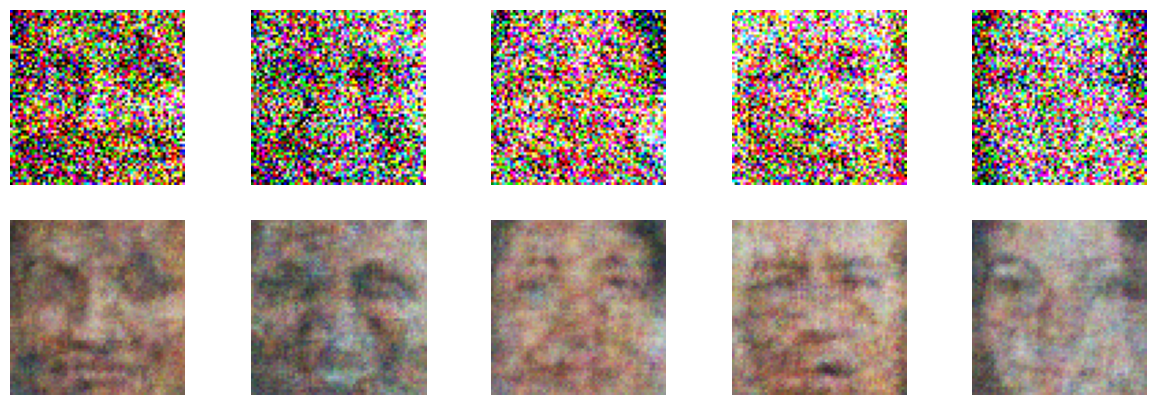

In [51]:
count = 5
sample_images = next(iter(noisy_valid_loader))[0][5 : 5 + count]
reconstructed, _ = autoencoder_noisy(sample_images)

fig, axes = plt.subplots(2, count, figsize=(15, 5))
for i in range(count):
    axes[0, i].imshow(sample_images[i].permute(1, 2, 0).cpu().numpy())
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].detach().permute(1, 2, 0).cpu().numpy())
    axes[1, i].axis('off')
plt.show

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [52]:
train_loader_without_shuffle = data_utils.DataLoader(train_data, batch_size=64, shuffle=False)
codes = []
autoencoder.eval()
with torch.no_grad():
    for x_batch in train_loader_without_shuffle:
        codes.append(autoencoder.encoder(x_batch.to(device)))
codes = torch.cat(codes).cpu()

In [53]:
from sklearn.neighbors import NearestNeighbors


model_neighbors = NearestNeighbors(n_neighbors=20).fit(codes)

In [57]:
def get_similar(image, n_neighbors = 5):
    # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей
    autoencoder.eval()
    with torch.no_grad():
        code = autoencoder.encoder(image.unsqueeze(0).to(device)).cpu()

    distances, nearest_indices = model_neighbors.kneighbors(code, n_neighbors=n_neighbors)
    idx = torch.tensor(nearest_indices).squeeze()

    return distances.squeeze(), train_loader_without_shuffle.dataset[idx]


In [60]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances, neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[10,8])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

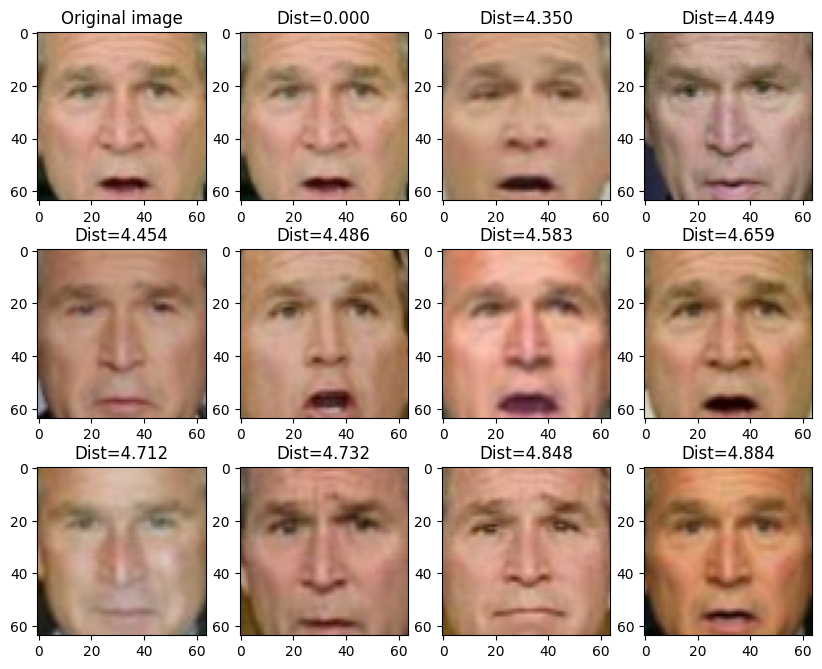

In [61]:
import random

random_photo = train_loader_without_shuffle.dataset[random.randint(0, train_data.data.shape[0])]
show_similar(random_photo)